In [1]:
import os
import gc
import zipfile
import random
import cv2
import numpy as np
from PIL import Image as im
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Concatenate
import glob
from time import time
from tensorflow.keras.regularizers import l2

#from google.colab import drive
#drive.mount('/content/drive')

PATH='./fake-circuit-data_copy/fake-circuit-data';
#os.chdir('/content/drive/My Drive/CAD_contest')
#os.listdir(PATH)
#print(os.listdir)
file_dir = os.listdir(PATH)
file_dir.sort()


2023-07-26 02:32:17.094124: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 02:32:17.623081: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("test")

test


In [3]:

#print(file_dir)
current_dir=[]
effdist_dir=[]
pdn_dir=[]
irdrop_dir=[]
for i in range(100):
  if(i<10):
    current_dir.append("current_map"+str(0)+str(i)+"_current.csv")
    effdist_dir.append("current_map"+str(0)+str(i)+"_eff_dist.csv")
    pdn_dir.append("current_map"+str(0)+str(i)+"_pdn_density.csv")
    irdrop_dir.append("current_map"+str(0)+str(i)+"_ir_drop.csv")
    #print(current_dir[i])
  else:
    current_dir.append("current_map"+str(i)+"_current.csv")
    effdist_dir.append("current_map"+str(i)+"_eff_dist.csv")
    pdn_dir.append("current_map"+str(i)+"_pdn_density.csv")
    irdrop_dir.append("current_map"+str(i)+"_ir_drop.csv")
    #print(current_dir[i])

current=np.zeros((100,512,512))
effdist=np.zeros((100,512,512))
pdnden=np.zeros((100,512,512))
irdrop=np.zeros((100,512,512))
print()
for i in range(100):
  df = pd.read_csv(PATH+"/"+current_dir[i], sep=',', header=None)
  arr=df.values
  #arr= (arr)*255
  arr=cv2.resize(arr, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
  current[i]=arr

  df = pd.read_csv(PATH+"/"+effdist_dir[i], sep=',', header=None)
  arr=df.values
  #arr= (arr/np.max(arr))*255
  arr=cv2.resize(arr, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
  effdist[i]=arr

  df = pd.read_csv(PATH+"/"+pdn_dir[i], sep=',', header=None)
  arr=df.values
  #arr= (arr/np.max(arr))*255
  arr=cv2.resize(arr, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
  pdnden[i]=arr

  df = pd.read_csv(PATH+"/"+irdrop_dir[i], sep=',', header=None)
  arr=df.values
  #arr= (arr/np.max(arr))*255
  arr=cv2.resize(arr, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
  irdrop[i]=arr

current=np.clip(current,0,255)
effdist=np.clip(effdist,0,255)
pdnden=np.clip(pdnden,0,255)
irdrop=np.clip(irdrop,0,255)


#current[0]=cv2.resize(current[0], dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
#print(irdrop[27].shape)

In [4]:
current_max=np.max(current)
effdist_max=np.max(effdist)
pdnden_max=np.max(pdnden)
irdrop_max=np.max(irdrop)

print(float(current_max))
print(effdist_max)
print(pdnden_max)
print(irdrop_max)

current_max=3.798046278242626e-07
effdist_max=61.38925466792125
pdnden_max=3
irdrop_max=0.006109428799003892

current=current/current_max
effdist=effdist/effdist_max
pdnden=pdnden/pdnden_max
irdrop=irdrop/irdrop_max

current=np.clip(current,0,1)
effdist=np.clip(effdist,0,1)
pdnden=np.clip(pdnden,0,1)
irdrop=np.clip(irdrop,0,1)

3.798046278242626e-07
61.38925466792125
3.7279207332314854
0.006109428799003892


In [5]:
print(len(current))
#print(current[5])
#print(current[5].shape)
flag=0
for i in range(100):
  #print(irdrop[i].shape)
  if(current[i].shape!=effdist[i].shape
     or effdist[i].shape!=pdnden[i].shape
     or pdnden[i].shape!=irdrop[i].shape):
    print("FAULT")
    flag=1

if(flag==0):print("DATA CORRECT")

100
DATA CORRECT


(512, 512)


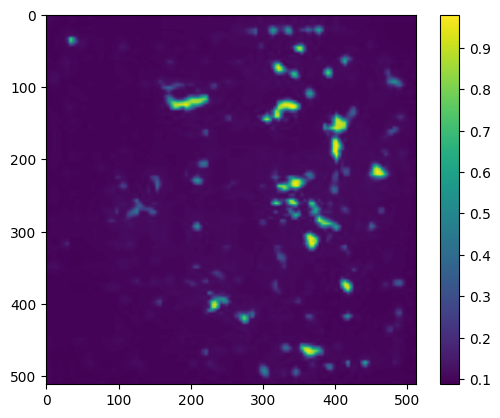

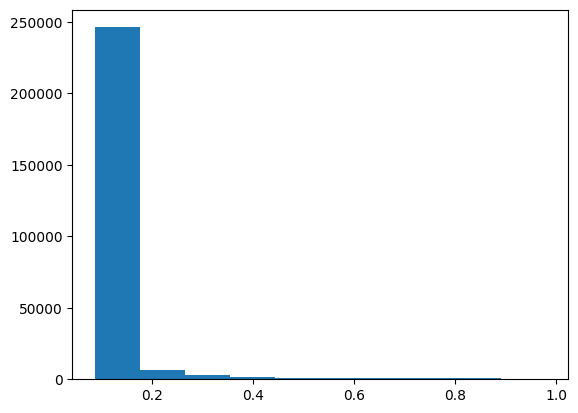

0.9798377947505877


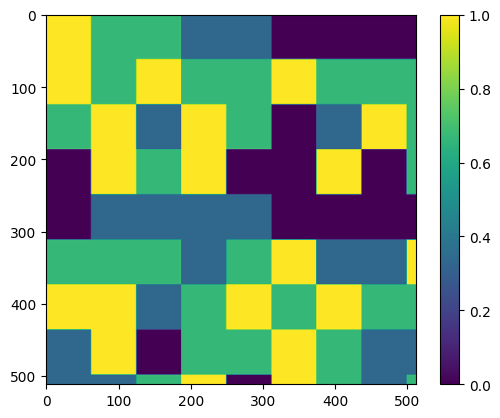

1.0


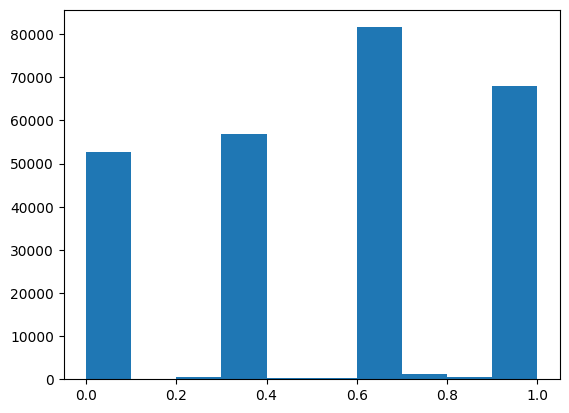

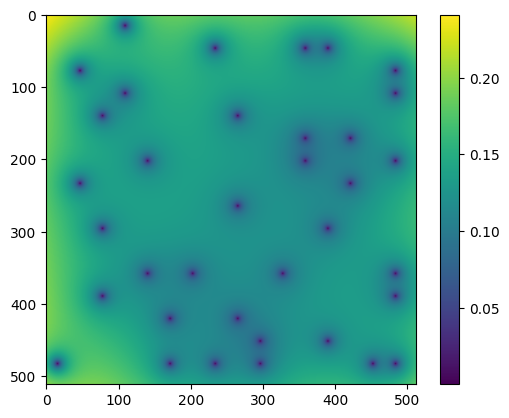

0.24107330734380636


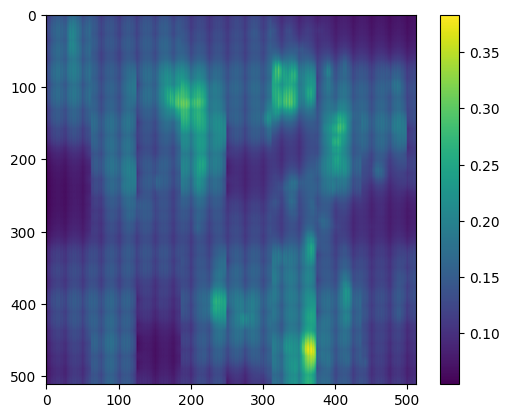

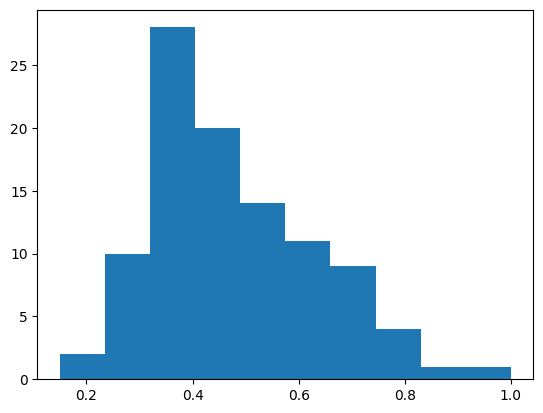

In [6]:
print(current[0].shape)

plt.imshow(current[0])
plt.colorbar()

plt.show()
counts, bins = np.histogram(current[0])
plt.hist(bins[:-1], bins, weights=counts)
plt.show()
print(np.max(current[0]))


plt.imshow(pdnden[0])
plt.colorbar()
plt.show()
print(np.max(pdnden[0]))
counts, bins = np.histogram(pdnden[0])
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

plt.imshow(effdist[0])
plt.colorbar()
plt.show()
print(np.max(effdist[0]))

plt.imshow(irdrop[0])
plt.colorbar()
plt.show()

maxir=np.zeros((100))
for i in range(100):
    maxir[i]=np.max(irdrop[i])
counts, bins = np.histogram(maxir)
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [7]:
dataset=np.zeros((100,512,512,3))
for i in range(100):
  t=np.stack((current[i], pdnden[i], effdist[i]), axis=2)
  #print(t)
  dataset[i]=t
del(current)
del(pdnden)
del(effdist)
dataset=dataset
irdrop=irdrop
irdrop=np.reshape(irdrop,(100,512,512,1))
"""
train_ds = tf.data.Dataset.from_tensor_slices(
    (power_map_train, temp_map_train)).batch(1)

test_ds = tf.data.Dataset.from_tensor_slices((power_map_test, temp_map_test)).batch(1)
"""

'\ntrain_ds = tf.data.Dataset.from_tensor_slices(\n    (power_map_train, temp_map_train)).batch(1)\n\ntest_ds = tf.data.Dataset.from_tensor_slices((power_map_test, temp_map_test)).batch(1)\n'

In [8]:
reg_rate =0.001
class encoder(Model):
  def __init__(self):
    super(encoder, self).__init__()
    self.conv1 = Conv2D(64, 3, activation='relu',padding='SAME',kernel_regularizer=l2(reg_rate), bias_regularizer=l2(reg_rate))
    self.max1 = MaxPooling2D(2, padding='same')
    self.conv2 = Conv2D(32, 3, activation='relu',padding='SAME',kernel_regularizer=l2(reg_rate), bias_regularizer=l2(reg_rate))
    self.max2 = MaxPooling2D(2, padding='same')
    self.conv3 = Conv2D(16, 5, activation='relu',padding='SAME',kernel_regularizer=l2(reg_rate), bias_regularizer=l2(reg_rate))
    self.max3 = MaxPooling2D(2, padding='same')
#     self.dense = Dense(128,activation='relu',kernel_regularizer=l2(reg_rate), bias_regularizer=l2(reg_rate))

  def call(self, x):
    x0 = self.conv1(x)

    x1 = self.max1(x0)
    x1 = self.conv2(x1)

    x2 = self.max2(x1)
    x2 = self.conv3(x2)

    x3 = self.max3(x2)

    return (x0,x1,x2,x3)

class decoder(Model):
  def __init__(self):
    super(decoder, self).__init__()
      #7->5
    self.conv0 = Conv2DTranspose(16, 7, activation='relu',padding='SAME',kernel_regularizer=l2(reg_rate), bias_regularizer=l2(reg_rate))
    self.max1 = UpSampling2D(2)
    self.conv1 = Conv2DTranspose(32, 7, activation='relu',padding='SAME',kernel_regularizer=l2(reg_rate), bias_regularizer=l2(reg_rate))
    self.max2 = UpSampling2D(2)
    self.conv2 = Conv2DTranspose(64, 3, activation='relu',padding='SAME',kernel_regularizer=l2(reg_rate), bias_regularizer=l2(reg_rate))
    self.max3 = UpSampling2D(2)
    self.conv3 = Conv2DTranspose(1, 3, activation='relu',padding='SAME',kernel_regularizer=l2(reg_rate), bias_regularizer=l2(reg_rate))



  def call(self, vals):
    x1 = self.conv0(vals[3])
    x1 = self.max1(x1)
    x1_shape = tf.shape(vals[2])
    x1 = tf.slice(x1, tf.zeros(x1_shape.shape,dtype=tf.dtypes.int32), x1_shape)
    x1 = Concatenate()([x1, vals[2]])

    x2 = self.conv1(x1)
    x2 = self.max2(x2)
    x2_shape = tf.shape(vals[1])
#     print(x2_shape)
    x2 = tf.slice(x2, [0,0,0,0], x2_shape)
    x2 = Concatenate()([x2, vals[1]])

    x3 = self.conv2(x2)
    x3 = self.max3(x3)
    x3_shape = tf.shape(vals[0])
    x3 = tf.slice(x3, [0,0,0,0], x3_shape)
#     x3 = tf.slice(x3, tf.zeros(x3_shape.shape,dtype=tf.dtypes.int32), x3_shape)
    x3 = Concatenate()([x3, vals[0]])

    x4 = self.conv3(x3)
    return x4

class autoencoder(Model):
  def __init__(self):
    super(autoencoder, self).__init__()
    self.ae = encoder()
    self.de = decoder()

  def call(self, x):
    vals = self.ae(x)
    x = self.de(vals)
    return x


# Create an instance of the model
model = autoencoder()

2023-07-26 02:32:38.629597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 02:32:38.630038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 02:32:38.653714: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

In [9]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.98,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mse', 'mae', 'mape'])

# In[ ]:
mx=0
mn=10000

st = time()

#model.summary()
#model.summary()
history=model.fit(dataset[0:94],irdrop[0:94], epochs=200,
              #steps_per_epoch=195,
          validation_data=(dataset[95:99],irdrop[95:99]),
          validation_freq=1
          #validation_steps=3
          )

Epoch 1/200


2023-07-26 02:32:40.285130: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2147483648 exceeds 10% of free system memory.
2023-07-26 02:32:42.060294: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2147483648 exceeds 10% of free system memory.
2023-07-26 02:32:42.180419: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4294967296 exceeds 10% of free system memory.
2023-07-26 02:32:42.938949: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4294967296 exceeds 10% of free system memory.
2023-07-26 02:32:43.247929: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2147483648 exceeds 10% of free system memory.


3/3 [==============================] - 28s 9s/step - loss: 0.2155 - mse: 0.0392 - mae: 0.1820 - mape: 98.6425 - val_loss: 0.1829 - val_mse: 0.0206 - val_mae: 0.1164 - val_mape: 50.5021
Epoch 2/200
3/3 [==============================] - 26s 9s/step - loss: 0.1710 - mse: 0.0137 - mae: 0.0906 - mape: 50.5904 - val_loss: 0.1614 - val_mse: 0.0134 - val_mae: 0.0883 - val_mape: 36.8537
Epoch 3/200
3/3 [==============================] - 27s 9s/step - loss: 0.1513 - mse: 0.0077 - mae: 0.0700 - mape: 36.4249 - val_loss: 0.1474 - val_mse: 0.0124 - val_mae: 0.0836 - val_mape: 33.5541
Epoch 4/200
3/3 [==============================] - 26s 9s/step - loss: 0.1357 - mse: 0.0047 - mae: 0.0500 - mape: 26.6819 - val_loss: 0.1295 - val_mse: 0.0065 - val_mae: 0.0627 - val_mape: 31.6765
Epoch 5/200
3/3 [==============================] - 27s 9s/step - loss: 0.1246 - mse: 0.0052 - mae: 0.0550 - mape: 32.9883 - val_loss: 0.1189 - val_mse: 0.0068 - val_mae: 0.0601 - val_mape: 25.5248
Epoch 6/200
3/3 [==========

1/1 [==============================] - 0s 307ms/step
(2, 512, 512, 1)


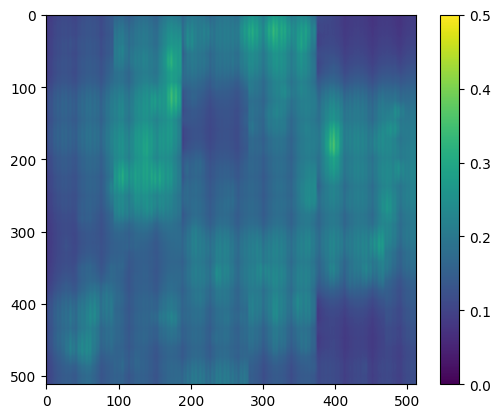

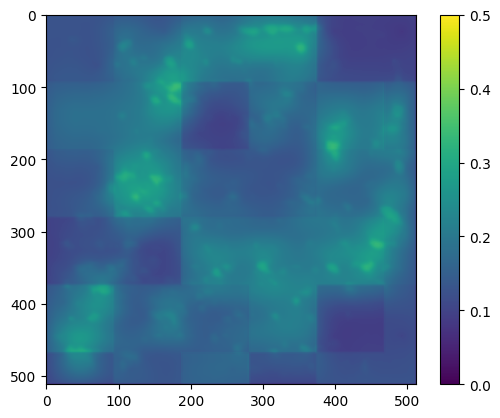

In [10]:
y_pred = model.predict(dataset[0:2])
print(y_pred.shape)

plt.imshow(irdrop[1],vmin=0,vmax=0.5)
plt.colorbar()
plt.show()
plt.imshow(y_pred[1],vmin=0,vmax=0.5)
plt.colorbar()
plt.show()

In [ ]:
from matplotlib import pyplot
# pyplot.plot(history.history['mse'])
# pyplot.plot(history.history['mae'])
pyplot.plot(history.history['mape'])
# pyplot.plot(history.history['cosine_proximity'])
pyplot.show()
pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['cosine_proximity'])
pyplot.show()

In [12]:
model.summary()
    

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (encoder)           multiple                  33072     
                                                                 
 decoder (decoder)           multiple                  100849    
                                                                 
Total params: 133921 (523.13 KB)
Trainable params: 133921 (523.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
